# Image Captioning using Vision Transformer and GPT-2
Using Vision Transformers (ViTs) in combination with models like GPT-2 for image captioning involves a two-step process: feature extraction from images using the Vision Transformer and then generating captions based on those extracted features using GPT-2.


ViTs divide an image into fixed-size non-overlapping patches, linearly embed them, and then process them in a series of transformer blocks to learn spatial hierarchies between patches. Once trained, ViTs can be used to extract feature vectors from images.

Once we have the feature vectors for the images, we can use them as input to a model like GPT-2 to generate captions.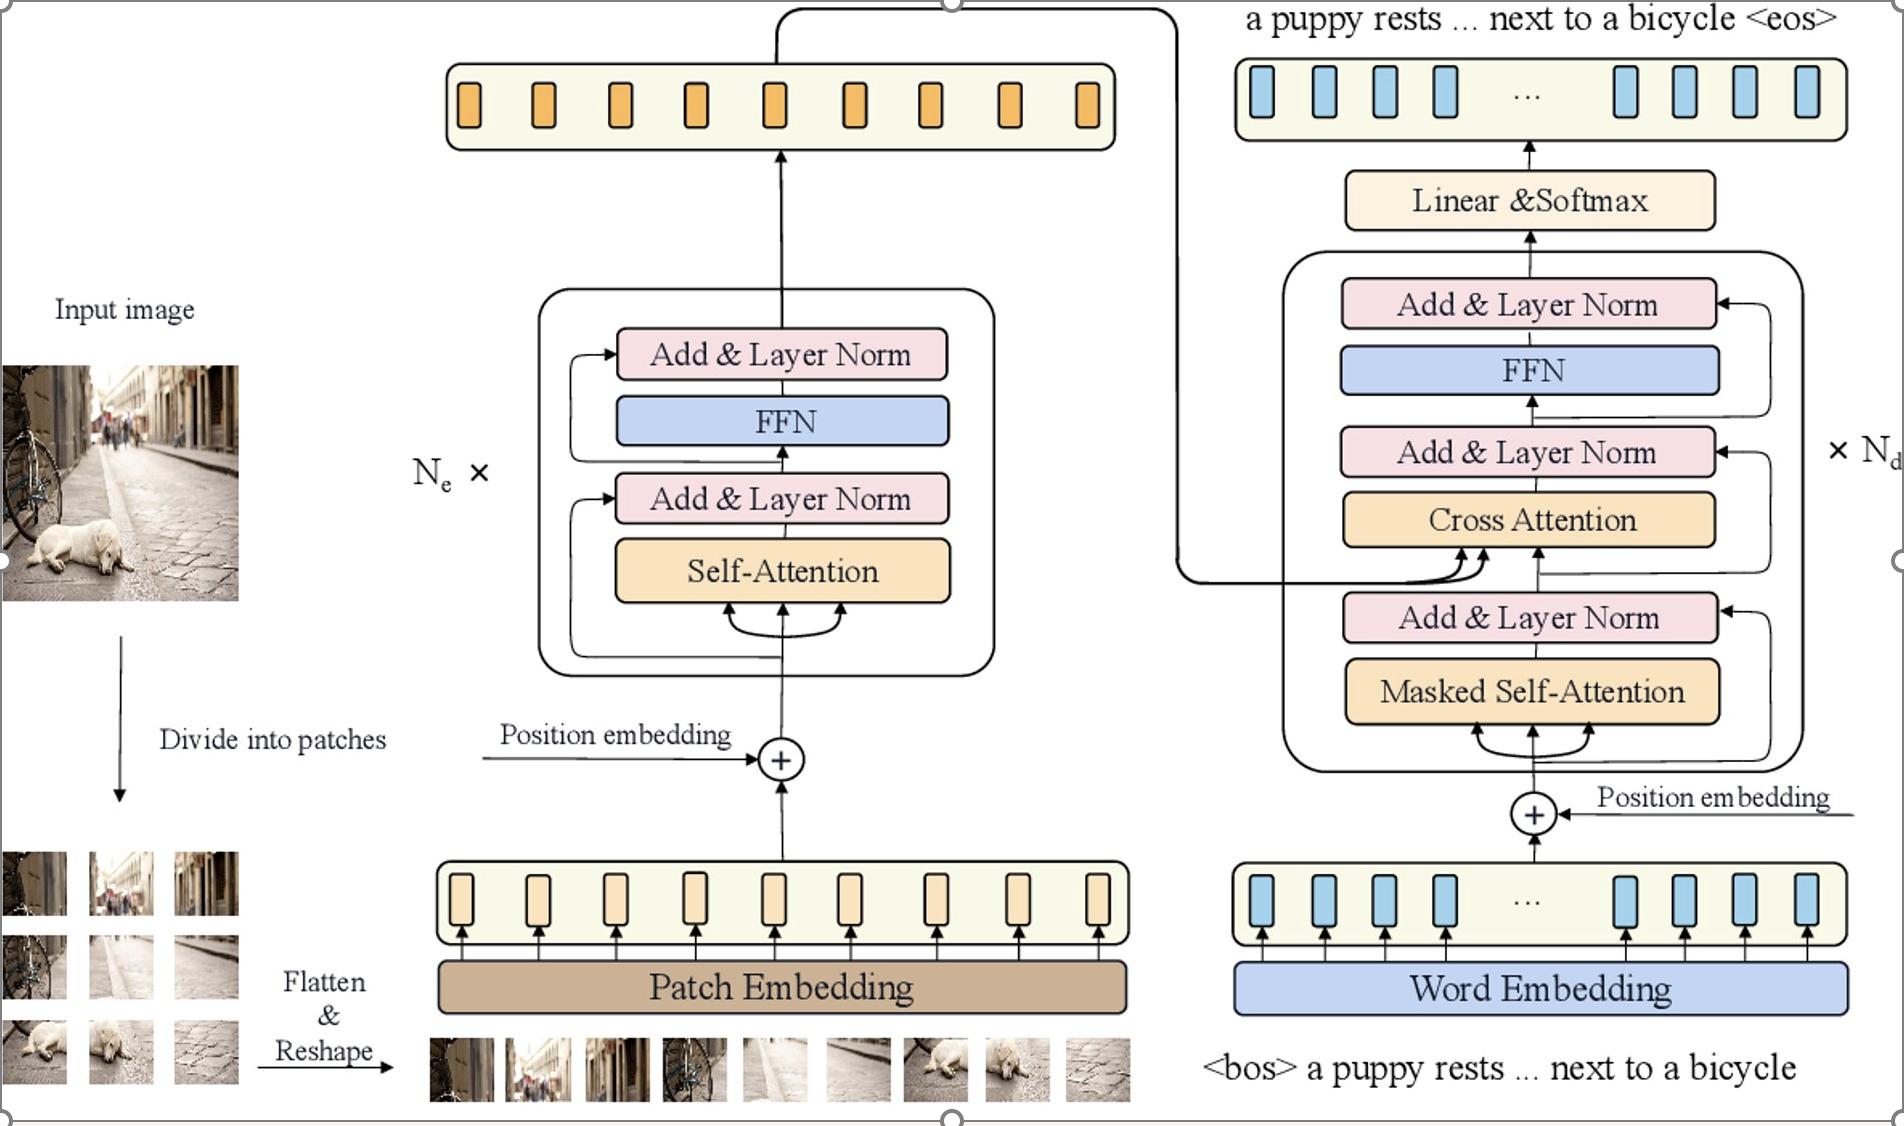


In [ ]:
!pip install datasets

In [1]:
import string
import pandas as pd
from pathlib import Path
import os
# from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Code to Troubleshoot if needed

In [ ]:


def count_images_in_directory(directory_path, image_extensions=['.jpg', '.jpeg', '.png', '.gif']):
    image_count = 0
    for filename in os.listdir(directory_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    return image_count

directory_path = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr8k/Flicker8k_Dataset"
image_count = count_images_in_directory(directory_path)

print(f"Number of images in directory: {image_count}")


In [ ]:
def count_lines_in_text_file(file_path):
    with open(file_path, 'r') as file:
        line_count = sum(1 for line in file)
    return line_count

text_file_path = "/path/to/your/text/file.txt"
line_count = count_lines_in_text_file(text_file_path)

print(f"Number of lines in the text file: {line_count}")


In [ ]:


# # create an empty dataframe with 'imgs' column
# df = pd.DataFrame(columns=['imgs'])
# # we will store the image files and captions here before putting it into dataframe
# imgs, captions = [], []
# # directory where the dataset is present
# root_dir = Path("/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr8k")

# # get the contents of 'captions.txt' file
# with open("/content/drive/MyDrive/Projects/DeepLearning/Datasets/Flickr8k/Flickr8k_text/descriptions.txt", "r") as f:
#     content = f.readlines()

## Prepare datasets

### Flickr8k

In [ ]:
import pandas as pd

def load_data(filename, image_path):
    data = []
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            parts = line.strip().split(',', 1)
            if len(parts) == 2:
                img_name = parts[0]
                img_path = os.path.join(image_path, img_name)
                if os.path.exists(img_path):
                    caption = parts[1]
                    data.append({'imgs': img_path, 'captions': caption})
    return data

image_folder = "/content/drive/MyDrive/Projects/Datasets/correctFlickr8k/Images"
dataset_text = "/content/drive/MyDrive/Projects/Datasets/Flickr8k/captions.txt"
data = load_data(dataset_text, image_folder)

df = pd.DataFrame(data)

print(df.head())
len(df)

### Memes

In [ ]:
import pandas as pd

import json

def img_capt(filename):
    descriptions = {}
    with open(filename, 'r') as file:
        data_list = json.load(file)  # Load the entire JSON list
        for data in data_list:
            img_name = os.path.basename(str(data['img_fname']))
            img_path = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/training/" + img_name
            descriptions[img_path] = data['captions']
    return descriptions

def load_data(descriptions):
    data = []
    for img_path, captions in descriptions.items():
        data.append({'imgs': img_path, 'captions': captions[-1]})  # Take the last caption
    return data

# Load descriptions from JSON and preprocess
dataset_text = "/content/drive/MyDrive/Projects/DeepLearning/Datasets/Memes/InterpretMemes/imagesAndCaptions.json"
descriptions = img_capt(dataset_text)

# Convert descriptions to desired data format
data = load_data(descriptions)

# Create a DataFrame
df = pd.DataFrame(data)

print(df.head())
print(len(df))





### Guns

Because we are also interested in training our model to know how to detect guns from an image we load in this Guns dataset.

In [ ]:
dataset = load_dataset("red_caps", split="train")
df = dataset.to_pandas()

# List of columns to drop
columns_to_drop = ['image_id', 'author', 'raw_caption', 'subreddit', 'score', 'created_utc', 'permalink', 'crosspost_parents']

# Drop the specified columns
limited_dataset = df.drop(columns=columns_to_drop)

# # Convert the modified DataFrame back to a Hugging Face dataset split
# modified_dataset = dataset['split_name'].from_pandas(df_dropped)
limited_dataset

Generating train split:   0%|          | 0/12011121 [00:00<?, ? examples/s]

,image_url,caption
0,http://i.imgur.com/VBg9K.jpg,ussr time abandoned appliances in some factory
1,http://i.imgur.com/s5KYB.jpg,"abandoned alley in porto, portugal"
2,http://i.imgur.com/X9zmL.jpg,mig 21 at an abandoned russian military base
3,http://i.imgur.com/EIg0f.jpg,me standing in front of one of many hangars in...
4,http://i.imgur.com/hwzwc.jpg,"abandoned brdm-2 in pripyat, ukraine"
...,...,...
12011116,https://i.imgur.com/WTscWjw.jpg,turn your used bottles into drinking glasses!
12011117,https://i.redd.it/g26w77rldi861.jpg,replacement lens help
12011118,https://i.redd.it/gmykw7sknj861.jpg,"my house is poorly insulated, and it's somethi..."
12011119,https://i.redd.it/dnzs8ctfbk861.jpg,reuse maple syrup bottle for vainilla.


In [ ]:
import pandas as pd
# Take only 8000 rows where the word gun is present
keyword = " gun "
filtered_rows = limited_dataset[limited_dataset["caption"].str.lower().str.contains(keyword)]
limited_filtered_rows = filtered_rows.head(8000)

limited_filtered_rows



,image_url,caption
2297,http://i.imgur.com/KkTSR.jpg,"abandoned gun turrets on bribie island beach, ..."
2464,http://i.imgur.com/vxARL.jpg,i was told at /r/guns that i should maybe post...
4284,http://i.imgur.com/aGBSPDD.jpg,"view from the gun port of a german bunker, nor..."
4929,http://farm1.staticflickr.com/246/524783430_7e...,japanese machine gun abandoned at iwo jima
5616,http://i.imgur.com/64ztcsY.jpg,"wwii-era gun guarding st. john's harbour, nl"
...,...,...
9406748,https://i.redd.it/0dbmek4g44p51.jpg,photo of machine gun kelly taken during his vm...
9407575,https://i.imgur.com/oRZlRHY.jpg,here's my quarantine bb gun gallery.
9411709,https://i.redd.it/veih8uww0tq51.jpg,r99 apex legend gun made by my little sister .
9427450,https://i.imgur.com/mpicSRk.jpg,"ladies and gents, my hometown pharmacy & gun s..."


In [ ]:
# !pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.7 MB/s eta 0:00:00


### Build our model with our encoder and decoder

In [ ]:
from transformers import AutoFeatureExtractor, AutoTokenizer

encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
#add padding to captions shorter than 128.
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# maximum length for the captions
max_length = 128
sample = limited_filtered_rows.iloc[0]

# sample image URL
image_url = sample['image_url']  # Replace 'img_url' with the actual column name containing URLs

# Download the image from the internet
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Sample caption
caption = sample['caption']

# Apply feature extractor on the downloaded image
inputs = feature_extractor(images=image, return_tensors='pt')

# Apply tokenizer
outputs = tokenizer(
    caption,
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='pt',
)


In [ ]:
# from PIL import Image

# # maximum length for the captions
# max_length = 128
# sample = df.iloc[0]

# # sample image
# image = Image.open(sample['imgs']).convert('RGB')
# # sample caption
# caption = sample['captions']

# # apply feature extractor on the sample image
# inputs = feature_extractor(images=image, return_tensors='pt')
# # apply tokenizer
# outputs = tokenizer(
#             caption,
#             max_length=max_length,
#             truncation=True,
#             padding='max_length',
#             return_tensors='pt',
#         )

In [ ]:
# Create function to load in our data that takes our images and captions , turns it into RGB and then gets the pixel values of the image for training

from torch.utils.data import Dataset
from PIL import Image
import requests
from io import BytesIO
import PIL

class LoadDataset(Dataset):
    def __init__(self, df):
        self.image_urls = df['image_url'].values  # Assuming you have a column named 'img_urls'
        self.captions = df['caption'].values

    def __getitem__(self, idx):
        inputs = dict()
        try:
            response = requests.get(image_url)
            response.raise_for_status()  # Raise an exception if the HTTP request has an error
            image = Image.open(BytesIO(response.content)).convert('RGB')
        except (requests.exceptions.RequestException, PIL.UnidentifiedImageError) as e:
            print(f"Error: {e}")
            # Handle the error, like using a default image or skipping this data point

        image = feature_extractor(images=image, return_tensors='pt')

        caption = self.captions[idx]
        labels = tokenizer(
            caption,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]

        inputs['pixel_values'] = image['pixel_values'].squeeze()
        inputs['labels'] = labels
        return inputs

    def __len__(self):
        return len(self.image_urls)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(limited_filtered_rows, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)

In [ ]:
from transformers import VisionEncoderDecoderModel
# initialise our model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_checkpoint,
    decoder_checkpoint
)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.2.ln_cross_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.7.crossattention.c_proj.bias', 'h.11.crossattention.q_attn.bias', 'h.2.ln_cross_attn.weight', 'h.8.crossattention.c_attn.bias', 'h.2.crossattention.q_attn.bias', 'h.4.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.10.ln_cross_attn.bias', 'h.9.crossattention.c_proj.weight', 'h.1.crossattention.c_proj.weight', 'h.7.crossattention.c_attn.weight', 'h.5.crossattention.c_proj.bias', 'h.8.crossattention.c_proj.weight', 'h.4.ln_cross_attn.weight', 'h.3.crossattention.c_attn.bias', 'h.5.crossattention.c_attn.bias', 'h.8.crossattention.c_attn.weight', 'h.7.crossattention.c_attn.bias', 'h.2.crossattention.c_attn.weight', 'h.4.crossattention.q_attn.bias', 'h.4.ln_cross_attn.bias', 'h.5.ln_cross_attn.weight', 'h.6.ln_cross_attn.bias', 'h.9.ln_cross_attn.weight', 'h.2

In [ ]:
#set a value for decoder_start_token_id and pad_token_id in the model config
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
# In order to get good and meaningful captions from the model,
# we should use beam search instead of greedy search while
# generating the caption. For that, we just have
# to set a value greater than 1 for num_beams in model config
num_beams = 4
model.config.num_beams = num_beams

In [ ]:
from transformers import Seq2SeqTrainingArguments

# batch size
bs = 32 #8

training_args = Seq2SeqTrainingArguments(
    output_dir="image-caption-generator", # name of the directory to store training outputs
    evaluation_strategy="epoch",          # evaluate after each epoch
    per_device_train_batch_size=bs,       # batch size during training
    per_device_eval_batch_size=bs,        # batch size during evaluation
    learning_rate=5e-5,
    weight_decay=0.01,                    # weight decay parameter for AdamW optimizer
    num_train_epochs=5,                   # number of epochs to train
    save_strategy='epoch',                # save checkpoints after each epoch
    report_to='none',                     # prevent reporting to wandb, mlflow...
)

In [ ]:
from transformers import Seq2SeqTrainer, default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    data_collator=default_data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    args=training_args,
)

trainer.train()

In [ ]:
# Get pixel values to test
inputs = test_ds[65]['pixel_values']



In [ ]:
# Carry out inference using our GPU
import torch

model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # generate caption for the image
    out = model.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=num_beams,
        )

# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)

NameError: ignored

In [ ]:
# Save our model
torch.save(model.state_dict(), "/content/drive/MyDrive/Projects/DeepLearning/Ofcom/imageCaptioningPreTrained/gune.pth")

In [ ]:
# Load our model back in for use
model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/DeepLearning/Ofcom/imageCaptioningPreTrained/bets_model.pth'))

<All keys matched successfully>

### Carry out inference

In [ ]:


import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Load your saved model and move it to GPU
model = model.to('cuda')
model.eval()  # Set the model to evaluation mode

# URL of the online image
image_url = "https://www.outdoorlife.com/uploads/2022/06/06/TJD05435-scaled.jpg?auto=webp"
# Download the image using requests
response = requests.get(image_url)
image_data = BytesIO(response.content)
image = Image.open(image_data).convert('RGB')

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor()  # Convert to tensor
])

# Apply the transformations to the image
input_tensor = preprocess(image).unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

with torch.no_grad():
    # Generate caption for the image
    out = model.generate(
        input_tensor,  # Use the preprocessed input tensor
        num_beams=num_beams,
    )

# Convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

print(decoded_out)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


"I think it's important for us to be able to do that," he said. "


### Do Demo

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.5 MB/s eta 0:00:00
  

In [ ]:
from transformers import VisionEncoderDecoderModel
from transformers import AutoFeatureExtractor, AutoTokenizer
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import gradio as gr

def demo(url):

  encoder_checkpoint = "google/vit-base-patch16-224-in21k"
  decoder_checkpoint = "gpt2"

  feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
  tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)


  model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
      encoder_checkpoint,
      decoder_checkpoint
  )

  #set a value for decoder_start_token_id and pad_token_id in the model config
  model.config.decoder_start_token_id = tokenizer.bos_token_id
  model.config.pad_token_id = tokenizer.pad_token_id

  # In order to get good and meaningful captions from the model,
  # we should use beam search instead of greedy search while
  # generating the caption. For that, we just have
  # to set a value greater than 1 for num_beams in model config
  num_beams = 4
  model.config.num_beams = num_beams

  model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/DeepLearning/Ofcom/imageCaptioningPreTrained/memes.pth'))


  # Load your saved model and move it to GPU
  model = model.to('cuda')
  model.eval()  # Set the model to evaluation mode

  # URL of the online image
  image_url = url
  # Download the image using requests
  response = requests.get(image_url)
  image_data = BytesIO(response.content)
  image = Image.open(image_data).convert('RGB')

  # Define the image preprocessing transformations
  preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize the image
      transforms.ToTensor()  # Convert to tensor
  ])

  # Apply the transformations to the image
  input_tensor = preprocess(image).unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

  with torch.no_grad():
      # Generate caption for the image
      out = model.generate(
          input_tensor,  # Use the preprocessed input tensor
          num_beams=num_beams,
      )

  # Convert token ids to string format
  decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

  # print(decoded_out)

  return decoded_out, image

In [ ]:
finalDemo = gr.Interface(fn = demo,inputs = "text", outputs = ["text", "image"])
finalDemo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>